## **Importing Packages**

In [ ]:
pip install contractions -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
#To Load Data in Colab
from google.colab import drive # Used to access Google Drive to import data
import shutil # Used to copy data from Google Drive

# General Packages
import pandas as pd
import numpy as np
import time

#Loading & Splitting Data
import gzip
import random
import json

from sklearn.model_selection import train_test_split

#Working with Text
import re
import contractions
from collections import Counter #To count words

import nltk #Tokenizing words
from nltk.tokenize import word_tokenize #Tokenizing words
from nltk.corpus import stopwords

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker #Eliminates scientific notation

#Training
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

#Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## **Checking GPU**

In [ ]:
torch.__version__

'2.5.1+cu121'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


# **<u>Part 1: Simplified Word2Vec Training</u>**



## **Step 1: Data Importationn & Preparation**

### **1.1 Import Data**

In [ ]:
#Mount to Google Drive to be able to access data (images & labels)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Define general path
path_dir = "/content/drive/My Drive/2) College & Other Education/1) College/1) Master of Science Data Science in Business & Economics/3. Semester/DS405B_Practical_Deep_Learning_for_Language_Processing/Assignments/Assignment 2"

In [ ]:
#Copy image data to local machine to allow for faster estimation.
shutil.copy(f"{path_dir}/Data/Electronics_5.json.gz", "Electronics_5.json.gz")

'Electronics_5.json.gz'

In [ ]:
#Source: https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/
def parse(path):
  g = gzip.open(path, "rb")
  for l in g:
    yield json.loads(l)

def getDF(path, data_sample_size, seed):

  #Set seed to replicate sample
  random.seed(seed)

  i = 0
  df = {}

  for d in parse(path):

    #Only data_sample_size% of the data is loaded
    if random.random() <= data_sample_size:
      df[i] = d
      i += 1

  #Return Dataframe
  return pd.DataFrame.from_dict(df, orient="index")

#Select subset of N% reviews for faster training.
data_sample_size = 0.01
seed = 603

amazon_reviews = getDF("Electronics_5.json.gz", data_sample_size, seed)

In [ ]:
print(f"Number of Reviews: {len(amazon_reviews)}")

Number of Reviews: 68003


In [ ]:
amazon_reviews.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,vote,image
0,5.0,True,"01 14, 2016",A1KV65E2TMMG6F,0511189877,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,1452729600,NaN,NaN,NaN
1,4.0,True,"07 11, 2014",AEZ3CR6BKIROJ,0594451647,Mark D.,"This adapter easily connects my Nook HD 7"" to ...",A nice easy to use accessory.,1405036800,NaN,NaN,NaN
2,4.0,False,"06 12, 2010",AHFGCH8LANEZK,0789743035,Dana G.,If you are new to the Mac operating system or ...,Friendly and easy to follow,1276300800,{'Format:': ' Paperback'},NaN,NaN
3,1.0,True,"06 15, 2017",A3K90YOHQJL8U7,0972683275,Mori M.,DID NOT fit as described to accommodate the T...,DID NOT fit as described to accommodate the TV...,1497484800,NaN,NaN,NaN
4,5.0,True,"07 29, 2014",ABWQ1SYDHUPPU,0972683275,me2colion,Super easy super strong!,Five Stars,1406592000,NaN,NaN,NaN


### **1.2 Cleanup and Preprocess text**

In [ ]:
nltk.download("punkt_tab")
nltk.download('stopwords') #I remove stop words from this analysis.

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def symbolsToWords(word):
  num_dict = {
        "0": "zero", "1": "one", "2": "two", "3": "three", "4": "four", "5": "five",
        "6": "six", "7": "seven", "8": "eight", "9": "nine", "&" : " and ", "@" : " at ", "$": " dollar "
  }

  return num_dict.get(word, word)

In [ ]:
special_characters = [
    "[", "!", "\\", "$", "%", "&", "\"", "(", ")", "*", "+", ",", "-", ".", "/",
    ":", ";", "<", "=", ">", "?", "@", "]", "^", "_", "`", "{", "|", "}", "~",
    ".", ";", "•", "«", "#", "'"
]

stop_words = set(stopwords.words("english"))
additional_stop_words = ["aa", "aaa", "aaaa", "aaaaa", "aaaaaa", "aaaaaaa"]
stop_words.update(additional_stop_words)

special_characters_pattern = f"[{re.escape(''.join(special_characters))}]"

#Source: Assignment 1
def cleanupText(s):
    """
    Given a text, cleans. Feel free to add your own stuff.
    """

    #If a value is not a string, it is converted to string
    if not isinstance(s, str):  # Check if the input is not a string
        s = f"{s}" #Converts non string values to strings

    #Sets every value to lower-case
    s = s.lower()

    # Replace IPs & URLs
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    s = re.sub(r'http\S+|www\S+', ' _url_ ', s)

    # Removes punctuation and special characters as they appear very often in text and don't add any meaningful information.
    s = re.sub(special_characters_pattern, " ", s)

    # Remove extra space left after punctuation removel
    s = re.sub(r'\s+', " ", s)

    # Remove HTML tags
    s = re.sub(r'<.*?>', " ", s)

    #Replaces don't, can't, etc. with do not, cannot, etc.
    s = contractions.fix(s)

    # Replace numbers and symbols with language
    s = re.sub(r'\d', lambda x: symbolsToWords(x.group(0)), s)

    # Remove stop words
    s = " ".join([word for word in s.split() if word not in stop_words])

    return s

In [ ]:
#Applying Functions to reviews
amazon_reviews["cleaned_reviewText"] = amazon_reviews["reviewText"].apply(cleanupText)
amazon_reviews["tokenized_reviewText"] = amazon_reviews["cleaned_reviewText"].apply(word_tokenize)

In [ ]:
amazon_reviews[["reviewText", "cleaned_reviewText", "tokenized_reviewText"]].head()

,reviewText,cleaned_reviewText,tokenized_reviewText
0,I got tired of the remote being on the wrong s...,got tired remote wrong side bed going buy gene...,"[got, tired, remote, wrong, side, bed, going, ..."
1,"This adapter easily connects my Nook HD 7"" to ...",adapter easily connects nook hd seven hdtv hdm...,"[adapter, easily, connects, nook, hd, seven, h..."
2,If you are new to the Mac operating system or ...,new mac operating system familiar would like b...,"[new, mac, operating, system, familiar, would,..."
3,DID NOT fit as described to accommodate the T...,fit described accommodate tv size,"[fit, described, accommodate, tv, size]"
4,Super easy super strong!,super easy super strong,"[super, easy, super, strong]"


## **Step 2: Vocabulary Creation**

### **2.1 Functions**

In [ ]:
#Returns Percentage of Words Below Threshold (PWBT
def getPWBT(word_frequencies, x):
  #Total amount of words
  total_words = len(word_frequencies)

  #Amount of words below x count
  below_x = sum(1 for word, count in word_frequencies.items() if count < x)

  #Percentage
  percentage = round((below_x / total_words) * 100, 2)

  return percentage

In [ ]:
def getWordFrequencies(words, min_count = 5):

  #Returns word frequencies
  word_frequencies = Counter(words)

  #Returns only those words for which the threshold is met
  word_frequencies = {word: count for word, count in word_frequencies.items() if count >= min_count}

  #Returns final dictionary
  return word_frequencies

In [ ]:
def createVocabulary(word_frequencies, threshold):

  #Only select those words that have a count above the threshold
  filtered_words = [(word, count) for word, count in word_frequencies.items() if count >= threshold]
  filtered_words = sorted(set(filtered_words)) #Sort Data

  #Get these words without the frequencies
  selected_words = [word for word, count in filtered_words]
  selected_words.extend(["<|end_of_review|>"]) #Adds token for end of review
  selected_words.extend(["<|unk|>"]) #Adds unknown token

  #Assigns Index to each word (Source: Lecture Notes)
  vocab = {token:integer for integer, token in enumerate(selected_words)}

  return vocab

In [ ]:
def plotBoxPlotOfWordFrequencies(word_frequencies):

  word_counts = list(word_frequencies.values())

  plt.figure(figsize=(10, 6))

  sns.boxplot(x=word_counts, color = ".8", linecolor = "#137", linewidth = 0.75)

  # Set labels and title
  plt.title("Word Count Boxplot")
  plt.xlabel("Word Count (Number of Occurrences)")

  #Since there are outliers with very large values, I use log-scale to make the plot more readable
  plt.xscale("log")

  # Removes scientific notation
  plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

  # Show the plot
  plt.show()

### **2.2 Apply Functions & Create Vocabulary**

In [ ]:
#I add all words from every review to a single list
all_words = []

for review_tokens in amazon_reviews["tokenized_reviewText"]:
  all_words.extend(review_tokens)

#### **2.21 Find good Minimum Count Threshold**

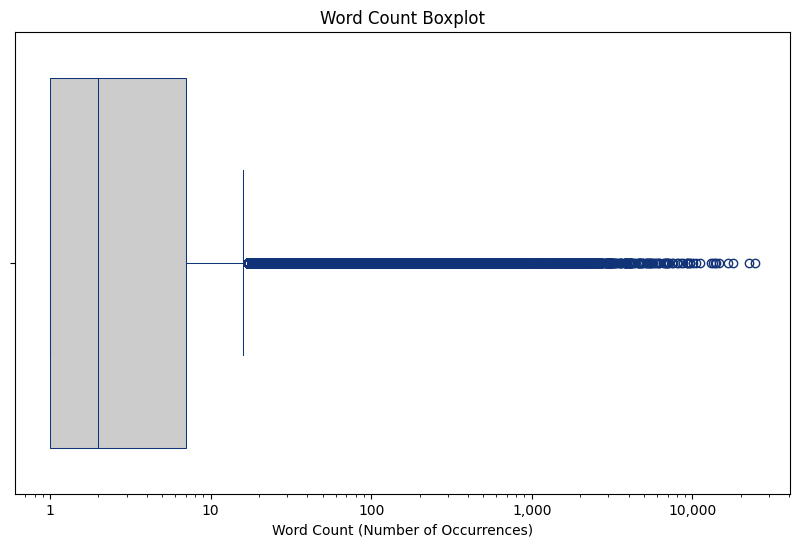

In [ ]:
#Get the word frequencies for every word
word_frequencies = getWordFrequencies(all_words, 1)

plotBoxPlotOfWordFrequencies(word_frequencies)

In [ ]:
sorted_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)

top_10_words = sorted_words[:10]

for word, freq in top_10_words:
    print(f"{word}: {freq}")

one: 24402
great: 22488
good: 17863
use: 16617
works: 14547
like: 14050
two: 13797
well: 13467
would: 13114
get: 11145


In [ ]:
print(f"The boxplot shows that {getPWBT(word_frequencies, 100)}% of words occur at most 100 times out of {len(all_words)} occurances!")

The boxplot shows that 94.25% of words occur at most 100 times out of 2318719 occurances!


Since these words probably don't add much meaningful information, I will set the threshold to 100 words. A good threshold could probably also be higher but since the negative and neutral reviews are underrepresented, I set this threshold to a smaller number so that the model can capture also meaningful words from these reviews even tho they don't appear as often as positive reviews

#### **2.22 Creates Vocabulary, Assigns Indices & Creates Word-To-Index and Index-To-Word Mappings**

In [ ]:
#Size of Vocabulary
threshold = 100

#Creates vocabulary
vocab = createVocabulary(word_frequencies, threshold)

In [ ]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 10:
        break

('ability', 0)
('able', 1)
('absolute', 2)
('absolutely', 3)
('abuse', 4)
('ac', 5)
('accept', 6)
('acceptable', 7)
('access', 8)
('accessible', 9)
('accessories', 10)


In [ ]:
print(f"The vocabulary has a {len(vocab.items())} words!")

The vocabulary has a 2842 words!


The length of the vocabulary (=V) will be the length of the matrix containing the weights that are trained in the Word2Vec Model. The embedding Size definied below is the width of the matrix

            d
     ________________
    |________________|
    |________________|
    |________________|
    |________________| V
    |________________|
    |________________|
    |________________|

In [ ]:
#Source: Class Slides
class Tokenizer:
  def __init__(self, vocab):
      self.str_to_int = vocab
      self.int_to_str = {i:s for s,i in vocab.items()}

  def encode(self, text):
      preprocessed = re.split(r' ', text.lower()) #String is converted to lower case as vocabulary only contains lower case words.
      preprocessed = [item.strip() for item in preprocessed if item.strip()]

      #I don't add a <|unk|> because these words are not needed as they are unknown.
      preprocessed = [
          item for item in preprocessed if item in self.str_to_int
      ]

      ids = [self.str_to_int[s] for s in preprocessed]
      return ids

  def decode(self, ids):
      text = " ".join([self.int_to_str[i] for i in ids])
      return text

In [ ]:
tokenizer = Tokenizer(vocab)

text = """What a great product! I love it! <|end_of_review|>"""

tokenizer.encode(text)

[1041, 1394, 2840]

As you can see, the tokenizer removes any unknown words. This is important for the text that will later be passed to the Word2Vec Model. Otherwise the text would contain a munch of "<|unk|>" in it which doesn't help us here at all. Once I removed the "<|unk|>", the performance of the model increased!

In [ ]:
tokenizer.decode(tokenizer.encode(text))

'great love <|end_of_review|>'

## **Step 3: Simplified Word2Vec Model**

In [ ]:
class SimplifiedWord2Vec(torch.nn.Module):
  def __init__(self, vocab_size, embedding_size):
    super(SimplifiedWord2Vec, self).__init__()

    self.embedding_layer = torch.nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_size)
    self.output_layer = torch.nn.Linear(embedding_size, vocab_size)

  #Specifies how the layers interact with each other to return the output
  def forward(self, center_word):

    embedding = self.embedding_layer(center_word) #Gets the embeddings for the center word.
    logits = self.output_layer(embedding) #Returns the log counts for every word in the vocabulary
    probabilities = F.softmax(logits, dim = 1) #Returns the log probs for every word in the vocab using softmax

    return logits, probabilities

## **Step 4: Word2Vec Training Data Preparation**

In [ ]:
#Source: Class Notes
class myTextDataset(Dataset):
  def __init__(self, txt, tokenizer, window_size = 2):

    self.input_ids = []
    self.target_ids = []

    # Tokenize the entire text
    token_ids = tokenizer.encode(txt)

    # Create sliding window pairs
    for i, input_id in enumerate(token_ids):
        # Create context window around the current token
        start = max(0, i - window_size)
        end = min(len(token_ids), i + window_size + 1)

        # Iterate over the context window
        for j in range(start, end):
            if i != j:  # Exclude the current token itself
                self.input_ids.append(input_id)
                self.target_ids.append(token_ids[j])

  #Returns the length of the whole dataset
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]

In [ ]:
def createDataLoader(txt, batch_size = 4, shuffle = False):

    # Initialize the tokenizer
    tokenizer = Tokenizer(vocab)

    # Create dataset
    dataset = myTextDataset(txt, tokenizer) #Window Size is already assigned with default value

    print(f"The Dataset has {len(dataset)} samples")
    print(f"There are {round((len(dataset) / batch_size), 2)} batches!")

    # Create dataloader
    dataloader = DataLoader(dataset, batch_size = batch_size, #Loads data in different batches
                            shuffle = shuffle, #Shuffles data
                            num_workers = 0 #How many parallel CPUs the dataloader should use to load the data in parallel.
                            )

    return dataloader

In [ ]:
def chunks(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

## **Step 5: Word2Vec Training**

**Set Hyper-Parameters**

In [ ]:
word2vec_batch_size = 7500
word2vec_embedding_size = 150
word2vec_num_epochs = 15
word2vec_learning_rate = 0.01

**Create Dataloader**

In [ ]:
reviews = amazon_reviews["cleaned_reviewText"].tolist()

#I add these two <|start_of_review|> and <|end_of_review|> to indicate the start and the ending of a new review.
reviews = [f"{review} <|end_of_review|>" for review in reviews]

#I join the reviews to a string in chunks because if I would do it at once, I would run out of memory
all_reviews = ''.join([' '.join(chunk) + ' ' for chunk in chunks(reviews, 1000)])

In [ ]:
word2vec_dataloader = createDataLoader(all_reviews, batch_size = word2vec_batch_size, shuffle = False)

The Dataset has 8260422 samples
There are 1101.39 batches!


**Word2Vec Model**

In [ ]:
vocab_size = len(vocab.items())

word2vec_model = SimplifiedWord2Vec(vocab_size, word2vec_embedding_size)
word2vec_optimizer = torch.optim.Adam(word2vec_model.parameters(), lr = word2vec_learning_rate)
word2vec_loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
word2vec_model.to(device)

SimplifiedWord2Vec(
  (embedding_layer): Embedding(2842, 150)
  (output_layer): Linear(in_features=150, out_features=2842, bias=True)
)

In [ ]:
next(word2vec_model.parameters()).device

device(type='cuda', index=0)

**Training**

In [ ]:
start_time = time.time()

word2vec_model.train()
losses = []

length_train = len(word2vec_dataloader)

#This is supposed to increase available memory
torch.cuda.empty_cache()

for epoch in range(word2vec_num_epochs):
  for i, (center_words, context_words) in enumerate(word2vec_dataloader):

    center_words = center_words.to(device) #The center word is the feature
    context_words = context_words.to(device) #The context words are the labels

    logits, probabilities = word2vec_model(center_words) #Forward Pass

    loss = word2vec_loss_fn(logits, context_words)

    #Performs gradient descent for current batch
    word2vec_optimizer.zero_grad()
    loss.backward() #Computes the gradient of the loss wight regard to the weights
    word2vec_optimizer.step() #Subtracts the gradients of the weights from the weights.

  #Appends losses to list
  losses.append(loss.item())

  torch.cuda.empty_cache()

  current_time = round((time.time() - start_time) / 60, 2) #Calculates current time
  current_epoch = epoch + 1

  print(f"Epoch: {current_epoch}, Loss: {loss.item()}, Time: {current_time} Minutes")

#Saving Model after training it.
torch.save(word2vec_model.state_dict(), f"{path_dir}/Models/Word2VecModel.pth")

Epoch: 1, Loss: 6.671701908111572, Time: 0.37 Minutes
Epoch: 2, Loss: 6.593991279602051, Time: 0.71 Minutes
Epoch: 3, Loss: 6.556797027587891, Time: 1.08 Minutes
Epoch: 4, Loss: 6.53833532333374, Time: 1.43 Minutes
Epoch: 5, Loss: 6.529768943786621, Time: 1.8 Minutes
Epoch: 6, Loss: 6.526217937469482, Time: 2.16 Minutes
Epoch: 7, Loss: 6.524696350097656, Time: 2.53 Minutes
Epoch: 8, Loss: 6.523720741271973, Time: 2.9 Minutes
Epoch: 9, Loss: 6.523011684417725, Time: 3.27 Minutes
Epoch: 10, Loss: 6.522725582122803, Time: 3.64 Minutes
Epoch: 11, Loss: 6.522604465484619, Time: 4.02 Minutes
Epoch: 12, Loss: 6.5225090980529785, Time: 4.38 Minutes
Epoch: 13, Loss: 6.52238130569458, Time: 4.75 Minutes
Epoch: 14, Loss: 6.522297382354736, Time: 5.11 Minutes
Epoch: 15, Loss: 6.522256374359131, Time: 5.48 Minutes


# **<u>Part 2: Sentiment Analysis</u>**



During training I had issues with predicting every single review to be a positive one. I think this was due to many different issues:

1. There is a strong imbalance of sentiment classifications. A large majority of reviews have a positive sentiment while only some are neutral or negative. To address this, I added weights to the CrossEntropyLoss function that reflect the underrepresentation of negative and neutral reviews. I also oversampled negative and neutral reviews relatively to positive reviews in the subset for the sentiment analysis.
2. I originally included more words (threshold = 10) in the Word2Vec model.
3. I padded the sequences in the Sentiment Model to the maximum review length in my subset. This resultet in many reviews including many "0". I then changed it so that instead the fixed length is equal to the median length of the reviews. This improved performance dramatically

## **Step 1: Create Labeled Subset**

**Label Data**

In [ ]:
def setSentiment(overall):
  if overall >= 4:
    return 0
  elif overall <= 2:
    return 1
  else:
    return 2

In [ ]:
#Sets sentiment for every review
amazon_reviews["Sentiment"] = amazon_reviews["overall"].apply(setSentiment)

As you can see, there is a strong imbalance in the data. Positive reviews make up about 80% of the data. Negative and Neutral Reviews make up only around 11% and 9% respectively.

In [ ]:
#View Distribution of Sentiment
sentiment_counts = amazon_reviews["Sentiment"].value_counts()

print(sentiment_counts)

Sentiment
0    55098
1     7775
2     5130
Name: count, dtype: int64


**Subset Data**

I subset the data and sample only 50% positive reviews. 30% are negative and 20% are neutral reviews. I decided not to sample equal sizes to still capture the nature of the data that positive reviews occur more often.

In [ ]:
sample_size = 0.1
random_state = 603

#Those are the shares that I want in my subset for the different classes.
class_shares = {
    0: 0.5,
    1: 0.3,
    2: 0.2
}

# Total number of samples based on sample size
# Need Integer for this to work
total_samples = int(len(amazon_reviews) * sample_size)

#I calculate the samples per class based on the proportions given in class_shares
samples_per_class = {
    sentiment: int(total_samples * proportion) for sentiment, proportion in class_shares.items()
}

#For each sentiment, I sample samples_per_class reviews. This is achieved by the groupby statement.
amazon_reviews_subset = (
    amazon_reviews
    .groupby("Sentiment", group_keys=False)
    .apply(lambda x: x.sample(n = samples_per_class[x.name], random_state = random_state))
    .reset_index(drop=True)
)

<ipython-input-47-0c02c5028cdb>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n = samples_per_class[x.name], random_state = random_state))


As you can see now, the sentiment classes are more balanced.

In [ ]:
#View Distribution of Sentiment
sentiment_counts = amazon_reviews_subset["Sentiment"].value_counts()

print(sentiment_counts)

Sentiment
0    3400
1    2040
2    1360
Name: count, dtype: int64


**Train-Test-Validation Split**

In [ ]:
#Set relative sizes
train_size = 0.8 #Saves 70% of data into train set
test_size = 0.05 #Saves 10% of data into test set
validation_size = 0.12625 / train_size #Saves 20% of the data into validation set

#Splits data into train, test and validation set
train_val, test_data = train_test_split(amazon_reviews_subset, test_size = test_size, shuffle = True, random_state = random_state)
train_data, validation_data = train_test_split(train_val, test_size = validation_size, shuffle = True, random_state = random_state)

train_data = train_data.reset_index(drop = True)
validation_data = validation_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)

#Gets total length of subset dataset
total_length = len(amazon_reviews_subset)

#Calculates relative size
training_size_rel = round((len(train_data) / total_length) * 100, 2)
validation_size_rel = round((len(validation_data) / total_length) * 100, 2)
test_size_rel = round((len(test_data) / total_length) * 100, 2)

#Prints sizes
print(f"Training Size: {len(train_data)} Reviews | {training_size_rel}%")
print(f"Validation Size: {len(validation_data)} Reviews | {validation_size_rel}%")
print(f"Test Size: {len(test_data)} Reviews | {test_size_rel}%")

Training Size: 5440 Reviews | 80.0%
Validation Size: 1020 Reviews | 15.0%
Test Size: 340 Reviews | 5.0%


## **Step 2: Sentiment Analysis Model**

In [ ]:
#Sentiment Analysis Model
class SentimentAnalysisModel(torch.nn.Module):
  def __init__(self, vocab_size, embedding_size, pretrained_embeddings_weights, freeze_embeddings, use_hidden_layer = False, hidden_size = 24, num_scores = 3):
    super(SentimentAnalysisModel, self).__init__()

    #Source: https://stackoverflow.com/questions/64919743/pytorch-use-pretrained-vectors-to-initialize-nn-embedding-but-this-embedding-l
    # Creates & Initializes embedding layer with pre-trained embedding weights.
    # Freeze option is based on argument given to model.
    self.embedding_layer = torch.nn.Embedding.from_pretrained(pretrained_embeddings_weights, freeze = freeze_embeddings)

    if use_hidden_layer:
      self.hidden_layer = torch.nn.Linear(embedding_size, hidden_size)
      self.output_layer = torch.nn.Linear(hidden_size, num_scores)
    else:
      self.hidden_layer = None
      self.output_layer = torch.nn.Linear(embedding_size, num_scores)

  #Foward
  def forward(self, input_ids):

    #Embedding layer
    embeddings = self.embedding_layer(input_ids)

    #Calculates average of embeddings
    average_embeddings = embeddings.mean(dim = 1)

    if self.hidden_layer:
      hidden_output = F.relu(self.hidden_layer(average_embeddings))
    else:
      hidden_output = average_embeddings

    #Scores for classes
    logits = self.output_layer(hidden_output)

    #Probabilities of scores
    probabilities = F.softmax(logits, dim = 1)

    #Returns probabilities
    return logits, probabilities

## **Step 3: Training Data Preparation**

**Tokenize the Reviews**

In [ ]:
#Tokenizing the reviews
train_data["review_token_ids"] = train_data["cleaned_reviewText"].apply(lambda rw: tokenizer.encode(rw))
validation_data["review_token_ids"] = validation_data["cleaned_reviewText"].apply(lambda rw: tokenizer.encode(rw))
test_data["review_token_ids"] = test_data["cleaned_reviewText"].apply(lambda rw: tokenizer.encode(rw))

In [ ]:
train_data[["cleaned_reviewText", "review_token_ids"]].head()

,cleaned_reviewText,review_token_ids
0,long range phone app works well three access p...,"[1377, 1941, 1746, 106, 2802, 2758, 2497, 8, 1..."
1,great,[1041]
2,software came unit work unit seems good alread...,"[2273, 321, 2643, 2799, 2643, 2134, 1030, 70, ..."
3,well verbatim disappoint least always enjoy ve...,"[2758, 1305, 75, 762, 665, 1942, 2581, 830, 12..."
4,use mountain bike find quite durable easy use ...,"[2671, 230, 881, 1931, 708, 728, 2671, 2221, 2..."


In [ ]:
#Keeping only the token ids
train_reviews = train_data["review_token_ids"]
validation_reviews = validation_data["review_token_ids"]
test_reviews = test_data["review_token_ids"]

**Pad the Sequences to a Fixed Length**

In [ ]:
#I understand padding a sequence as adding zeros to a given list until the number of values in that list matches a given number.
def padSequenceToFixedLength(sequences):

  #I pad the sequences to the median length of all sequences
  sequence_lengths = [len(sequence) for sequence in sequences]
  median_length = int(np.median(sequence_lengths))

  #Sequence is empty at beginning
  padded_sequences = []

  #Sequences are all reviews as token ids
  #I loop over each sequence
  for sequence in sequences:

    #Check if the length of the current sequence is smaller than the max value
    if len(sequence) < median_length:

      #In this case I take the sequence and add as many zeros until the max length value is reached
      sequence = sequence + [0] * (median_length - len(sequence))
    else:

      #Otherwise I set the sequence to sequence until the max length value is reached (In case the max_lenght variable is smaller than the current sequence is long)
      sequence = sequence[:median_length]

    #I then add the padded sequence to the list
    padded_sequences.append(sequence)

  #I return the list of lists of sequences
  return padded_sequences


In [ ]:
#Pads sequences for all reviews of the datasets
train_reviews_padded = padSequenceToFixedLength(train_reviews)
validation_reviews_padded = padSequenceToFixedLength(validation_reviews)
test_reviews_padded = padSequenceToFixedLength(test_reviews)

**Converting lists to Tensors (Needed for Training)**

In [ ]:
#I convert the lists to tensors. I also convert the sentiment values to tensors as the y
train_X = torch.tensor(train_reviews_padded)
train_y = torch.tensor(train_data["Sentiment"].values)

validation_X = torch.tensor(validation_reviews_padded)
validation_y = torch.tensor(validation_data["Sentiment"].values)

test_X = torch.tensor(test_reviews_padded)
test_y = torch.tensor(test_data["Sentiment"].values)

In [ ]:
train_X #These are the ids of the words in the vocabulary

tensor([[1377, 1941, 1746,  ...,   81,  952,    0],
        [1041,    0,    0,  ...,    0,    0,    0],
        [2273,  321, 2643,  ...,    0,    0,    0],
        ...,
        [1379, 1577,  728,  ...,    0,    0,    0],
        [1018, 1617,    5,  ...,    0,    0,    0],
        [ 217,  322,  894,  ..., 1414, 2298, 2778]])

In [ ]:
train_y #This are the sentiment labels

tensor([0, 0, 2,  ..., 2, 2, 2])

## **Step 4: Training**

**Set Hyper-Parameters**

In [ ]:
batch_size = 8
num_epochs = 60
learning_rate = 0.0001

**Creating Dataloaders**

In [ ]:
#Source: https://stackoverflow.com/questions/41924453/pytorch-how-to-use-dataloaders-for-custom-datasets
train_dataset = TensorDataset(train_X, train_y)
validation_dataset = TensorDataset(validation_X, validation_y)
test_dataset = TensorDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
print(f"The Dataset has {len(train_dataset)} samples")
print(f"There are {round((len(train_dataset) / batch_size), 2)} batches!")

The Dataset has 5440 samples
There are 680.0 batches!


**Get Embedding Weights of Word2Vec Model**

As explained above, the shape of the embedding_weights matches the length of the vocabulary (Length) and the embedding size (Width)

In [ ]:
#The embedding weights
pre_trained_embedding_weights = word2vec_model.embedding_layer.weight.data

In [ ]:
word2vec_model.embedding_layer.weight.data

tensor([[ 0.3640,  0.0423, -0.4635,  ..., -0.0111, -0.0374,  0.4062],
        [ 0.0917, -0.1746, -0.1777,  ..., -0.1183,  0.2920,  0.1226],
        [-0.1087,  0.0892,  0.2548,  ..., -0.4702, -0.5947,  0.1918],
        ...,
        [-0.4594,  0.0785, -0.3195,  ...,  0.3571, -0.4904,  0.3782],
        [ 0.0983,  0.0114,  0.0154,  ..., -0.0647, -0.0631,  0.0864],
        [-0.4562,  0.5571, -0.1672,  ..., -0.6217, -0.5470, -0.2783]],
       device='cuda:0')

In [ ]:
pre_trained_embedding_weights.shape

torch.Size([2842, 150])

In [ ]:
print(f"Vocabulary Size: {len(vocab)}")
print(f"Embedding Size: {word2vec_embedding_size}")

Vocabulary Size: 2842
Embedding Size: 150


**Instantiate the Model, Optimizer, and Loss Function**

In [ ]:
sentiment_analaysis_model = SentimentAnalysisModel(
    vocab_size,
    word2vec_embedding_size,
    pre_trained_embedding_weights,
    freeze_embeddings = True
)

optimizer = torch.optim.Adam(sentiment_analaysis_model.parameters(), lr = learning_rate)

#Calculate weights to address imbalanced data
#Source: https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75
sentiment_counts = amazon_reviews_subset["Sentiment"].value_counts()
total_count = sentiment_counts.sum()
weights = total_count / sentiment_counts

class_weights = torch.tensor(weights.values, dtype=torch.float).to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight = class_weights) #I use class weights to minimize imbalance problems of data

In [ ]:
print(f"Weighs used for Cross Entropy Loss: {weights}")

Weighs used for Cross Entropy Loss: Sentiment
0    2.000000
1    3.333333
2    5.000000
Name: count, dtype: float64


In [ ]:
sentiment_analaysis_model.to(device)

SentimentAnalysisModel(
  (embedding_layer): Embedding(2842, 150)
  (output_layer): Linear(in_features=150, out_features=3, bias=True)
)

In [ ]:
next(sentiment_analaysis_model.parameters()).device

device(type='cuda', index=0)

**Training**

In [ ]:
#Function calculates the accuracy
def getAccuracy(probabilities, labels):

  #Predicted label is the one with the highest probability
  _, predicted_labels = torch.max(probabilities, dim = 1)

  #Calculates how many predictions were accuracy
  correct = (predicted_labels == labels).sum().item()

  #Calculates accuracy in percent
  accuracy = (correct / len(labels)) * 100

  #Returns accuracy
  return accuracy, predicted_labels

In [ ]:
def evaluateModel(model, dataloader, loss_function, device):
  #Set Evaluation Mode
  model.eval()

  all_sentiment_labels = []
  all_predictions = []

  running_loss = 0
  running_accuracy = 0

  #Don't compute Gradients
  with torch.no_grad():
    #Loops over each batch in Validation Set
    for vocab_ids, sentiment_labels in dataloader:

      vocab_ids = vocab_ids.to(device)
      sentiment_labels = sentiment_labels.to(device)

      #Get Predictions on Validation Set
      logits, probabilities = model(vocab_ids)

      #Get Loss on Validation Set
      loss = loss_fn(logits, sentiment_labels)

      #Returns accuracy and predicted_labels
      accuracy, predicted_labels = getAccuracy(probabilities, sentiment_labels)

      #Calculates loss and Accuracy for current batch and adds it to running sums
      running_loss = running_loss + loss.item()
      running_accuracy = running_accuracy + accuracy

      all_sentiment_labels.extend(sentiment_labels.cpu().numpy())
      all_predictions.extend(predicted_labels.cpu().numpy())

  #Calculates average Loss and Accuracy of Training Data
  avg_loss = running_loss / len(dataloader)
  avg_accuracy = round(running_accuracy / len(dataloader), 2)

  return avg_loss, avg_accuracy, all_sentiment_labels, all_predictions

In [ ]:
def trainSentimentModel(model, num_epochs, dataloader, optimizer, loss_fn):
  start_time = time.time()

  #I keep the loss and accuracy values in a list for plotting
  training_loss = []
  training_accuracy = []

  validation_loss = []
  validation_accuracy = []

  #Loops over each Epoch!
  for epoch in range(num_epochs):

    #Set model to training mode at beginning of each epoch as it is set to eval at end of each epoch for Validation loss calcualtion
    model.train()

    #
    # Training
    #

    #At the beginning of each epoch, I set the running sum to zero
    running_train_loss = 0
    running_train_accuracy = 0

    #Loop over each batch!
    for i, (vocab_ids, sentiment_labels) in enumerate(dataloader):

      vocab_ids = vocab_ids.to(device)
      sentiment_labels = sentiment_labels.to(device)

      #Get predicted sentiment labels (or rather the probabilities)
      logits, probabilities = model(vocab_ids) #Forward Pass

      #Calculate loss based on predictions and true values
      loss = loss_fn(logits, sentiment_labels)

      #Perform Gradient Descent for current Batch!
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #Returns accuracy and predicted_labels
      accuracy, _ = getAccuracy(probabilities, sentiment_labels)

      #Calculates loss and Accuracy for current batch and adds it to running sums
      running_train_loss = running_train_loss + loss.item()
      running_train_accuracy = running_train_accuracy + accuracy

    #Calculates average Loss and Accuracy of Training Data
    avg_training_loss = running_train_loss / len(dataloader)
    avg_training_accuracy = round(running_train_accuracy / len(dataloader), 2)

    #Add current average values to lists
    training_loss.append(avg_training_loss)
    training_accuracy.append(avg_training_accuracy)

    #
    # Validation
    #

    avg_validation_loss, avg_validation_accuracy, _, _ = evaluateModel(
        model,
        validation_dataloader,
        loss_fn,
        device
    )

    #Add current average values to lists
    validation_loss.append(avg_validation_loss)
    validation_accuracy.append(avg_validation_accuracy)

    #
    # Printing
    #

    current_time = round((time.time() - start_time) / 60, 2) #Calculates current time
    current_epoch = epoch + 1

    print(" ")
    print(f"Epoch: {current_epoch}, Time: {current_time} Minutes")
    print(f"Training Set: Loss {avg_training_loss} | Accuracy {avg_training_accuracy}%")
    print(f"Validation Set: Loss {avg_validation_loss} | Accuracy {avg_validation_accuracy}%")

  return model, training_loss, training_accuracy, validation_loss, validation_accuracy

In [ ]:
trained_sentiment_analaysis_model, training_loss, training_accuracy, validation_loss, validation_accuracy = trainSentimentModel(sentiment_analaysis_model,
                                                                                                                                num_epochs,
                                                                                                                                train_dataloader,
                                                                                                                                optimizer,
                                                                                                                                loss_fn)

 
Epoch: 1, Time: 0.02 Minutes
Training Set: Loss 1.0889659677358234 | Accuracy 40.51%
Validation Set: Loss 1.084458279889077 | Accuracy 41.31%
 
Epoch: 2, Time: 0.03 Minutes
Training Set: Loss 1.0772147911436418 | Accuracy 43.27%
Validation Set: Loss 1.0785268796607852 | Accuracy 44.24%
 
Epoch: 3, Time: 0.05 Minutes
Training Set: Loss 1.0706054002923124 | Accuracy 46.31%
Validation Set: Loss 1.073413174599409 | Accuracy 46.09%
 
Epoch: 4, Time: 0.07 Minutes
Training Set: Loss 1.0649361922460443 | Accuracy 49.28%
Validation Set: Loss 1.0684091285802424 | Accuracy 46.58%
 
Epoch: 5, Time: 0.08 Minutes
Training Set: Loss 1.059824117492227 | Accuracy 51.16%
Validation Set: Loss 1.0637153587304056 | Accuracy 47.85%
 
Epoch: 6, Time: 0.1 Minutes
Training Set: Loss 1.0546806908705655 | Accuracy 52.1%
Validation Set: Loss 1.0595246264711022 | Accuracy 48.93%
 
Epoch: 7, Time: 0.11 Minutes
Training Set: Loss 1.0493174417053952 | Accuracy 52.9%
Validation Set: Loss 1.055397148244083 | Accuracy

**Accuracy Development**

In [ ]:
def plotTrainingAndValidationAccuracy(training_accuracy, validation_accuracy):

  x = list(range(1, len(validation_accuracy) + 1))

  #Plots Training & Validation Accuracy
  sns.lineplot(x = x, y = training_accuracy, label = "Training Accuracy")
  sns.lineplot(x = x, y = validation_accuracy, label = "Validation Accuracy")

  #Sets title & labels
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy in %")
  plt.title("Training & Validation Accuracy")

  #Puts legend in top right corner
  plt.legend(loc = "upper right", bbox_to_anchor = (1.4, 1), frameon = False)

  #Shows plot
  plt.show()

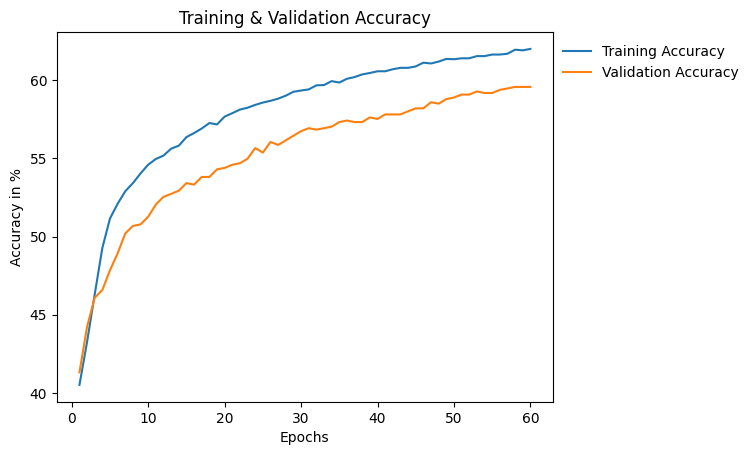

In [ ]:
plotTrainingAndValidationAccuracy(training_accuracy, validation_accuracy)

I decided to manually set the number of epochs to a value where I could see that the validation accuracy wasn't improving much anymore. Next time, to increase the sophistication of the model, I could add a stop training function that automatically stops training once the validation accuracy doesn't improve anymore

## **Step 5: Evaluation**

In [ ]:
avg_test_loss, avg_test_accuracy, test_sentiment_labels, test_predictions = evaluateModel(
    trained_sentiment_analaysis_model,
    test_dataloader,
    loss_fn,
    device
)

print(f"Test Loss: {avg_test_loss}")
print(f"Test Accuracy: {avg_test_accuracy}%")
print(" ")
report = classification_report(test_sentiment_labels, test_predictions, target_names=["Positive", "Negative", "Neutral"])
print(report)

Test Loss: 0.9629213213920593
Test Accuracy: 58.72%
 
              precision    recall  f1-score   support

    Positive       0.69      0.72      0.71       169
    Negative       0.55      0.60      0.58       102
     Neutral       0.30      0.23      0.26        69

    accuracy                           0.59       340
   macro avg       0.52      0.52      0.51       340
weighted avg       0.57      0.59      0.58       340



**Confusion Matrix**

In [ ]:
def plotConfusionMatrix(test_sentiment_labels, test_predictions):
  conf_matrix = confusion_matrix(test_sentiment_labels, test_predictions)

  plt.figure(figsize=(8, 6))

  labels = ["Positive", "Negative", "Neutral"]

  #Plot heatmap
  sns.heatmap(conf_matrix,
              annot = True,
              fmt = "d",
              cmap = "Blues",
              xticklabels = labels,
              yticklabels = labels
  )

  #Set title & labels
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")

  plt.show()

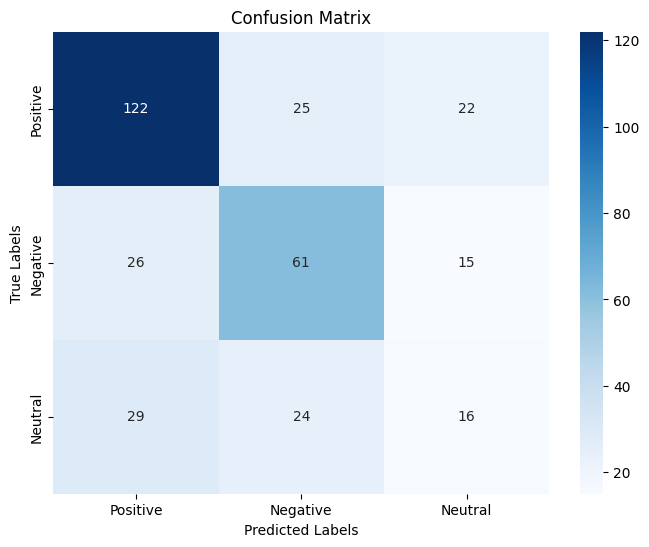

In [ ]:
plotConfusionMatrix(test_sentiment_labels, test_predictions)

The model correctly predicts the majority of positive and negative cases. Only for neutral cases, the model doesn't predict the majority correctly. This can likely be attributed to the fact that they are not represented as much in the data.

The negative sentiment class still has many cases where the model predicted them to be positive even though they are negative.

Overall, the model predicts 58.72% of reviews correctly

# **<u>Part 3: Extension to the Model</u>**



### **Add a hidden Layer to the Sentiment Classifier**

In [ ]:
sentiment_analaysis_model_2 = SentimentAnalysisModel(
    vocab_size,
    word2vec_embedding_size,
    pre_trained_embedding_weights,
    freeze_embeddings = True,
    use_hidden_layer = True,
    hidden_size = 27
)

optimizer_2 = torch.optim.Adam(sentiment_analaysis_model_2.parameters(), lr = learning_rate)
loss_fn_2 = torch.nn.CrossEntropyLoss(weight = class_weights) #I use class weights to minimize imbalance problems of data

num_epochs_2 = 15

sentiment_analaysis_model_2.to(device)

SentimentAnalysisModel(
  (embedding_layer): Embedding(2842, 150)
  (hidden_layer): Linear(in_features=150, out_features=27, bias=True)
  (output_layer): Linear(in_features=27, out_features=3, bias=True)
)

In [ ]:
trained_sentiment_analaysis_model_2, _, training_accuracy_2, _, validation_accuracy_2 = trainSentimentModel(sentiment_analaysis_model_2,
                                                                                                                                num_epochs_2,
                                                                                                                                train_dataloader,
                                                                                                                                optimizer_2,
                                                                                                                                loss_fn_2)

 
Epoch: 1, Time: 0.02 Minutes
Training Set: Loss 1.0957991312531863 | Accuracy 49.83%
Validation Set: Loss 1.0898944665677845 | Accuracy 47.85%
 
Epoch: 2, Time: 0.04 Minutes
Training Set: Loss 1.076352340333602 | Accuracy 50.99%
Validation Set: Loss 1.072666727937758 | Accuracy 51.37%
 
Epoch: 3, Time: 0.06 Minutes
Training Set: Loss 1.0571172005989973 | Accuracy 55.75%
Validation Set: Loss 1.0546957817859948 | Accuracy 54.3%
 
Epoch: 4, Time: 0.08 Minutes
Training Set: Loss 1.038970369714148 | Accuracy 55.33%
Validation Set: Loss 1.038953592069447 | Accuracy 54.88%
 
Epoch: 5, Time: 0.1 Minutes
Training Set: Loss 1.0229150655515054 | Accuracy 56.54%
Validation Set: Loss 1.0256092143245041 | Accuracy 55.37%
 
Epoch: 6, Time: 0.11 Minutes
Training Set: Loss 1.008277126270182 | Accuracy 57.32%
Validation Set: Loss 1.0114551479928195 | Accuracy 57.23%
 
Epoch: 7, Time: 0.13 Minutes
Training Set: Loss 0.9931888434816809 | Accuracy 59.01%
Validation Set: Loss 0.9983519050292671 | Accuracy

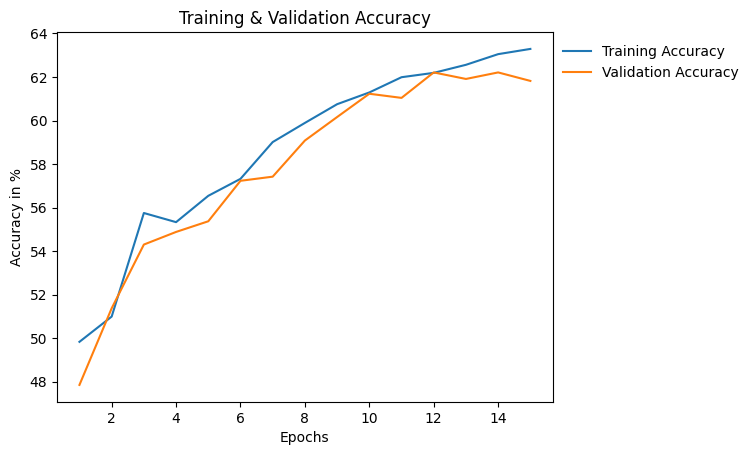

In [ ]:
plotTrainingAndValidationAccuracy(training_accuracy_2, validation_accuracy_2)

In [ ]:
avg_test_loss_2, avg_test_accuracy_2, test_sentiment_labels_2, test_predictions_2 = evaluateModel(
    trained_sentiment_analaysis_model_2,
    test_dataloader,
    loss_fn_2,
    device
)

print(f"Test Loss: {avg_test_loss_2}")
print(f"Test Accuracy: {avg_test_accuracy_2}%")
print(" ")
report_2 = classification_report(test_sentiment_labels_2, test_predictions_2, target_names=["Positive", "Negative", "Neutral"])
print(report_2)

Test Loss: 0.9446390964264093
Test Accuracy: 58.14%
 
              precision    recall  f1-score   support

    Positive       0.66      0.75      0.70       169
    Negative       0.58      0.62      0.60       102
     Neutral       0.20      0.12      0.15        69

    accuracy                           0.58       340
   macro avg       0.48      0.49      0.48       340
weighted avg       0.54      0.58      0.56       340



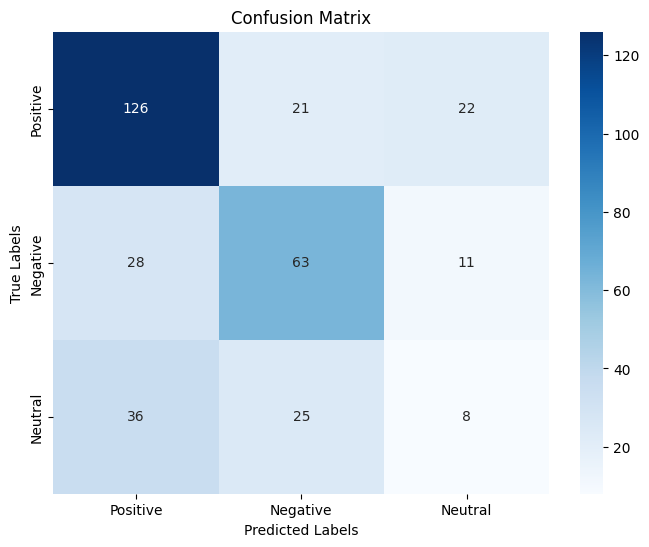

In [ ]:
plotConfusionMatrix(test_sentiment_labels_2, test_predictions_2)

The model that includes a hidden layer (but still freezes the embeddings) performs slightly better than the original model for positive and negative reviews. Neutral reviews on the other hand got worse! This explains the slight decline in total accuracy to 58.14%.

As the validation accuracy didn't improve at all (even starts to decline) after training for a little above 10 epochs, I stopped training at 15 epochs).

### **Try Impact of Fine-Tuning the Pre-Trained Embeddings**

In [ ]:
sentiment_analaysis_model_3 = SentimentAnalysisModel(
    vocab_size,
    word2vec_embedding_size,
    pre_trained_embedding_weights,
    freeze_embeddings = False
)

num_epochs_3 = 10

optimizer_3 = torch.optim.Adam(sentiment_analaysis_model_3.parameters(), lr = learning_rate)
loss_fn_3 = torch.nn.CrossEntropyLoss(weight = class_weights) #I use class weights to minimize imbalance problems of data

sentiment_analaysis_model_3.to(device)

SentimentAnalysisModel(
  (embedding_layer): Embedding(2842, 150)
  (output_layer): Linear(in_features=150, out_features=3, bias=True)
)

In [ ]:
trained_sentiment_analaysis_model_3, training_loss_3, training_accuracy_3, validation_loss_3, validation_accuracy_3 = trainSentimentModel(sentiment_analaysis_model_3,
                                                                                                                                num_epochs_3,
                                                                                                                                train_dataloader,
                                                                                                                                optimizer_3,
                                                                                                                                loss_fn_3)

 
Epoch: 1, Time: 0.02 Minutes
Training Set: Loss 0.9540249967399765 | Accuracy 79.03%
Validation Set: Loss 0.9736344679258764 | Accuracy 59.96%
 
Epoch: 2, Time: 0.04 Minutes
Training Set: Loss 0.7740391833817257 | Accuracy 85.53%
Validation Set: Loss 0.9341967937070876 | Accuracy 60.84%
 
Epoch: 3, Time: 0.06 Minutes
Training Set: Loss 0.6587594552075162 | Accuracy 87.1%
Validation Set: Loss 0.9270600059535354 | Accuracy 60.55%
 
Epoch: 4, Time: 0.08 Minutes
Training Set: Loss 0.5805618509431095 | Accuracy 88.03%
Validation Set: Loss 0.9377034746576101 | Accuracy 59.77%
 
Epoch: 5, Time: 0.09 Minutes
Training Set: Loss 0.5259473178973969 | Accuracy 88.47%
Validation Set: Loss 0.9595972232054919 | Accuracy 59.86%
 
Epoch: 6, Time: 0.11 Minutes
Training Set: Loss 0.48416715989656306 | Accuracy 88.6%
Validation Set: Loss 0.9865685950499028 | Accuracy 60.06%
 
Epoch: 7, Time: 0.13 Minutes
Training Set: Loss 0.4532854855279712 | Accuracy 88.68%
Validation Set: Loss 1.0166578921489418 | Ac

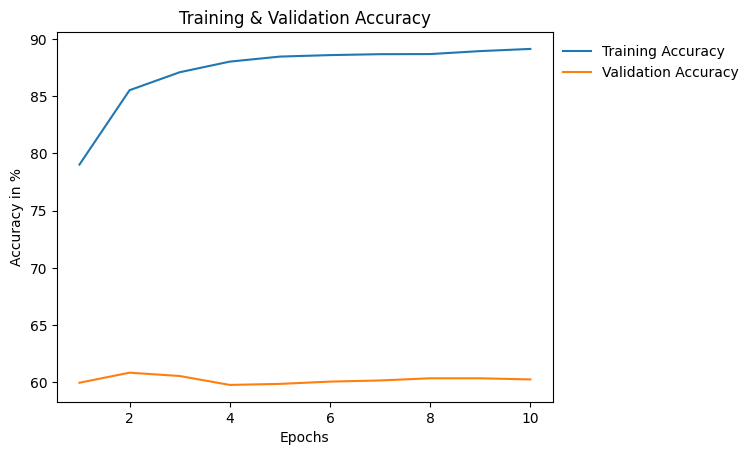

In [ ]:
plotTrainingAndValidationAccuracy(training_accuracy_3, validation_accuracy_3)

In [ ]:
avg_test_loss_3, avg_test_accuracy_3, test_sentiment_labels_3, test_predictions_3 = evaluateModel(
    trained_sentiment_analaysis_model_3,
    test_dataloader,
    loss_fn_3,
    device
)

print(f"Test Loss: {avg_test_loss_3}")
print(f"Test Accuracy: {avg_test_accuracy_3}%")
print(" ")
report_3 = classification_report(test_sentiment_labels_3, test_predictions_3, target_names=["Positive", "Negative", "Neutral"])
print(report_3)

Test Loss: 1.003661796450615
Test Accuracy: 64.24%
 
              precision    recall  f1-score   support

    Positive       0.75      0.76      0.76       169
    Negative       0.65      0.66      0.65       102
     Neutral       0.34      0.33      0.34        69

    accuracy                           0.64       340
   macro avg       0.58      0.58      0.58       340
weighted avg       0.64      0.64      0.64       340



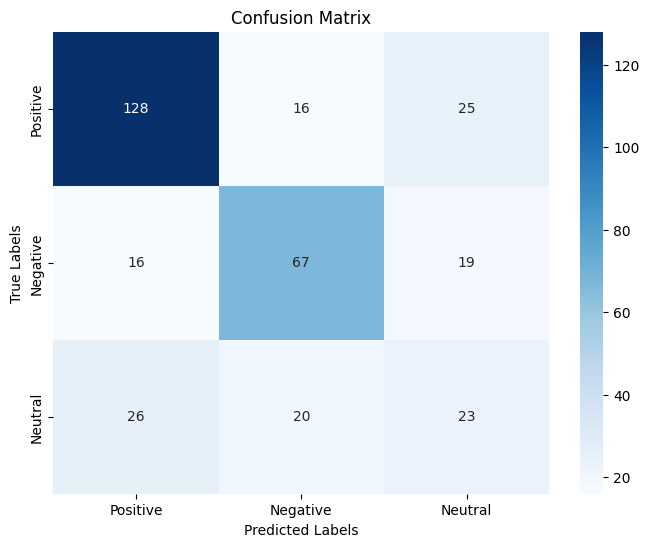

In [ ]:
plotConfusionMatrix(test_sentiment_labels_3, test_predictions_3)

By allowing the pre trained embeddings to be trained again, I observe strong overfitting. However, 64% of the test reviews are correctly predicted. The training data was able to predict almost 90% correctly tho. Nevertheless, more positive and negative reviews were correctly predicted in the test set. Predicting neutral reviews got worse tho explaining the decline in total accuracy

# **<u>Part 4: Comparison with Random Embeddings</u>**



**Create Random Embeddings Matrix**

In [ ]:
vocab_size = len(vocab)
embedding_size = word2vec_embedding_size

In [ ]:
random_embedding_weights = torch.randn(vocab_size, embedding_size)
print("Embedding matrix shape:", random_embedding_weights.shape)

Embedding matrix shape: torch.Size([2842, 150])


**Training with Random Embeddings**

In [ ]:
sentiment_analaysis_model_4 = SentimentAnalysisModel(
    vocab_size,
    word2vec_embedding_size,
    random_embedding_weights,
    freeze_embeddings = False
)

optimizer_4 = torch.optim.Adam(sentiment_analaysis_model_4.parameters(), lr = learning_rate)
loss_fn_4 = torch.nn.CrossEntropyLoss(weight = class_weights) #I use class weights to minimize imbalance problems of data

num_epochs_4 = 20

sentiment_analaysis_model_4.to(device)

SentimentAnalysisModel(
  (embedding_layer): Embedding(2842, 150)
  (output_layer): Linear(in_features=150, out_features=3, bias=True)
)

In [ ]:
trained_sentiment_analaysis_model_4, training_loss_4, training_accuracy_4, validation_loss_4, validation_accuracy_4 = trainSentimentModel(sentiment_analaysis_model_4,
                                                                                                                                num_epochs_4,
                                                                                                                                train_dataloader,
                                                                                                                                optimizer_4,
                                                                                                                                loss_fn_4)

 
Epoch: 1, Time: 0.02 Minutes
Training Set: Loss 1.0837791538413832 | Accuracy 44.52%
Validation Set: Loss 1.07760353339836 | Accuracy 46.19%
 
Epoch: 2, Time: 0.04 Minutes
Training Set: Loss 1.0712114862659399 | Accuracy 46.99%
Validation Set: Loss 1.068192015402019 | Accuracy 48.24%
 
Epoch: 3, Time: 0.06 Minutes
Training Set: Loss 1.059280727102476 | Accuracy 49.45%
Validation Set: Loss 1.058396914973855 | Accuracy 50.1%
 
Epoch: 4, Time: 0.08 Minutes
Training Set: Loss 1.0477649297784357 | Accuracy 51.51%
Validation Set: Loss 1.050258235540241 | Accuracy 51.07%
 
Epoch: 5, Time: 0.09 Minutes
Training Set: Loss 1.0369890682837541 | Accuracy 53.14%
Validation Set: Loss 1.0414612763561308 | Accuracy 52.73%
 
Epoch: 6, Time: 0.11 Minutes
Training Set: Loss 1.025306797816473 | Accuracy 54.61%
Validation Set: Loss 1.0330259907059371 | Accuracy 53.61%
 
Epoch: 7, Time: 0.13 Minutes
Training Set: Loss 1.0137616118964028 | Accuracy 55.62%
Validation Set: Loss 1.0232855025678873 | Accuracy 

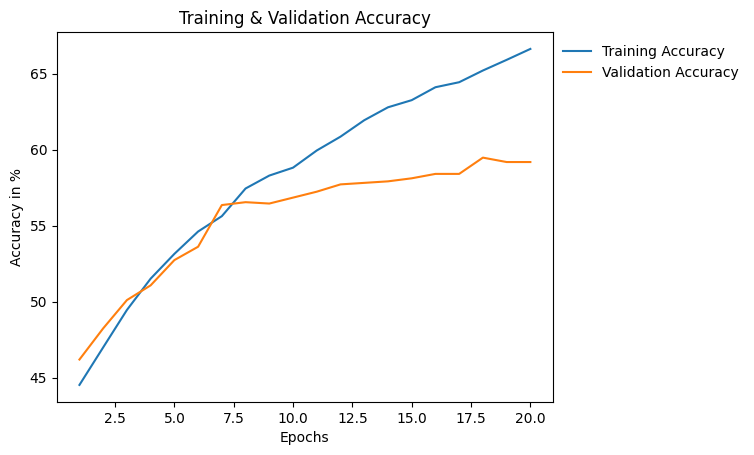

In [ ]:
plotTrainingAndValidationAccuracy(training_accuracy_4, validation_accuracy_4)

In [ ]:
avg_test_loss_4, avg_test_accuracy_4, test_sentiment_labels_4, test_predictions_4 = evaluateModel(
    trained_sentiment_analaysis_model_4,
    test_dataloader,
    loss_fn_4,
    device
)

print(f"Test Loss: {avg_test_loss_4}")
print(f"Test Accuracy: {avg_test_accuracy_4}%")
print(" ")
report_4 = classification_report(test_sentiment_labels_4, test_predictions_4, target_names=["Positive", "Negative", "Neutral"])
print(report_4)

Test Loss: 0.9601104966429777
Test Accuracy: 56.1%
 
              precision    recall  f1-score   support

    Positive       0.69      0.70      0.69       169
    Negative       0.52      0.54      0.53       102
     Neutral       0.29      0.26      0.27        69

    accuracy                           0.56       340
   macro avg       0.50      0.50      0.50       340
weighted avg       0.56      0.56      0.56       340



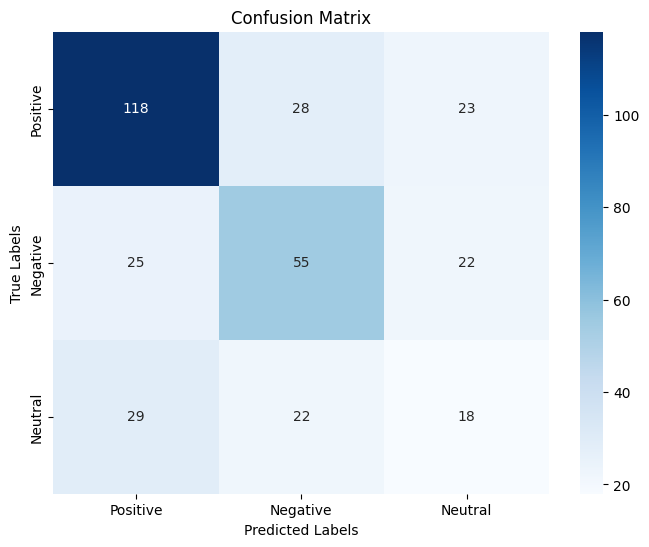

In [ ]:
plotConfusionMatrix(test_sentiment_labels_4, test_predictions_4)

The model with random embeddings performs worst of all. It has only a 56.1% accuracy for the test data. The overall pattern of predicting mostly correct the positive and negative sentiment is the same here as well.

I can also observe quick overfitting as the training accuracy increases sharply while the validation accuracy stagnates after around 20 epochs.

## **Final Review**

In [ ]:
print(f"Test Accuracy (First Model): {avg_test_accuracy}%")
print(f"Test Accuracy (With Hidden Layer): {avg_test_accuracy_2}%")
print(f"Test Accuracy (Unfreezing Embeddings): {avg_test_accuracy_3}%")
print(f"Test Accuracy (Random Embeddings): {avg_test_accuracy_4}%")

Test Accuracy (First Model): 58.72%
Test Accuracy (With Hidden Layer): 58.14%
Test Accuracy (Unfreezing Embeddings): 64.24%
Test Accuracy (Random Embeddings): 56.1%


The model that fine-tuned the embeddings performed best with over 64% accuracy. The model with random embeddings performed worst with 56.1% accuracy. Including a hidden layer led to quick overfitting and resulting in a slightly worst test accuracy.